In [20]:
import mne
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

from mne.decoding import CSP

Load Dataset

In [21]:
data = scipy.io.loadmat('./BCICIV_calib_ds1e.mat', struct_as_record=True)
# data = scipy.io.loadmat('/content/drive/MyDrive/ML Project/BCICIV_calib_ds1a.mat', struct_as_record=True)
sfreq = data['nfo']['fs'][0][0][0][0]
EEGdataa   = 0.1 * np.double(data['cnt'].T)
nchannels, nsamples = EEGdataa.shape

chan_names = [s[0] for s in data['nfo']['clab'][0][0][0]]

event_onsets  = data['mrk'][0][0][0]
event_codes   = data['mrk'][0][0][1]

labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in data['nfo']['classes'][0][0][0]]
cl1    = cl_lab[0]
cl2    = cl_lab[1]

xpos = data['nfo']['xpos']
ypos = data['nfo']['ypos']

nclasses = len(cl_lab)
nevents = len(event_onsets)

print('Shape of EEG:', EEGdataa.shape)
print('Sample rate:', sfreq)
print('Number of channels:', nchannels)
print('Channel names:', chan_names)
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)

Shape of EEG: (59, 190329)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events: 1
Event codes: [-1  1]
Class labels: ['left', 'right']
Number of classes: 2


Shape of trials[cl1]: (59, 400, 100)
Shape of trials[cl2]: (59, 400, 100)
(100, 59, 400)
(100, 59, 400)
Event created : <Info | 7 non-empty values
 bads: []
 ch_names: AF3, AF4, F5, F3, F1, Fz, F2, F4, F6, FC5, FC3, FC1, FCz, FC2, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 100.0 Hz
>


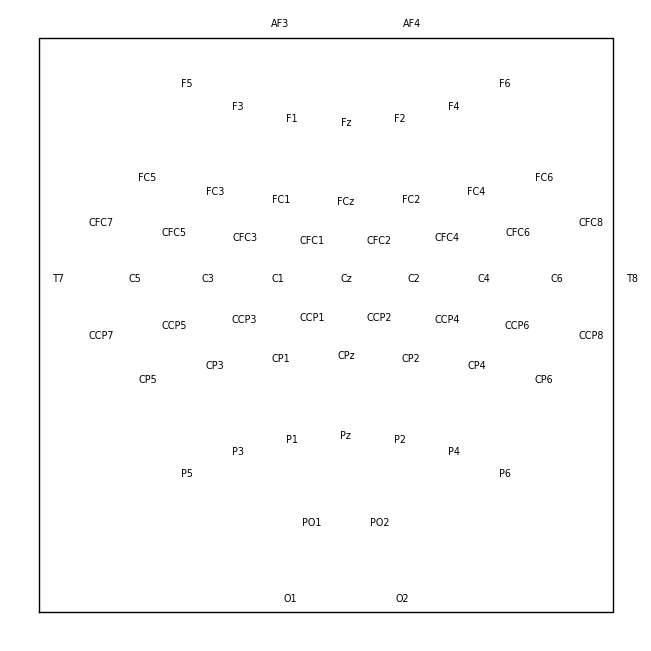

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


Number of events,200
Events,left: 100right: 100
Time range,0.500 – 4.490 s
Baseline,off


In [22]:
trials = {}

# The time window to extract for each trial, here 0.5 -- 4.5 seconds
win = np.arange(int(0.5*sfreq), int(4.5*sfreq))
# Length of the time window
nsamples = len(win)

# Loop over the classes (right, foot)
for cl, code in zip(cl_lab, np.unique(event_codes)):
    # Extract the onsets for the class
    cl_onsets = event_onsets[event_codes == code]
    # Allocate memory for the trials
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    # Extract each trial
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEGdataa[:, win+onset]

# the dimensionality of the dataa (channels x time x trials)
print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)

left  = np.rollaxis(trials[cl1], 2, 0)
foot = np.rollaxis(trials[cl2], 2, 0)

print(left.shape)
print(foot.shape)

dataa = np.concatenate([left, foot])

# create labels
Y = np.concatenate([-np.ones(left.shape[0]), np.ones(foot.shape[0])])

# Initialize an info structure
info = mne.create_info(
        ch_names = chan_names,
        ch_types = ['eeg']*nchannels,
        sfreq    = sfreq )

print('Event created :', info)
xpos = data['nfo']['xpos'][0][0]
ypos = data['nfo']['ypos'][0][0]

layout_pos = np.concatenate([xpos, ypos], axis = 1)
layout_pos

layout = mne.channels.generate_2d_layout(xy = layout_pos, ch_names=chan_names, name ='EEG custom layout', )
layout.plot()

event_id = dict(left = -1, right = 1)

# Create an event matrix: events with alternating event codes
eventLength = Y.shape[0]
ev = [i*sfreq*3 for i in range(eventLength)]

events = np.column_stack((np.array(ev,  dtype = int), np.zeros(eventLength,  dtype = int), np.array(Y,  dtype = int)))

tmin = 0.5

# Create the :class:`mne.EpochsArray` object
epochs = mne.EpochsArray(dataa, info, events, tmin, event_id)
epochs

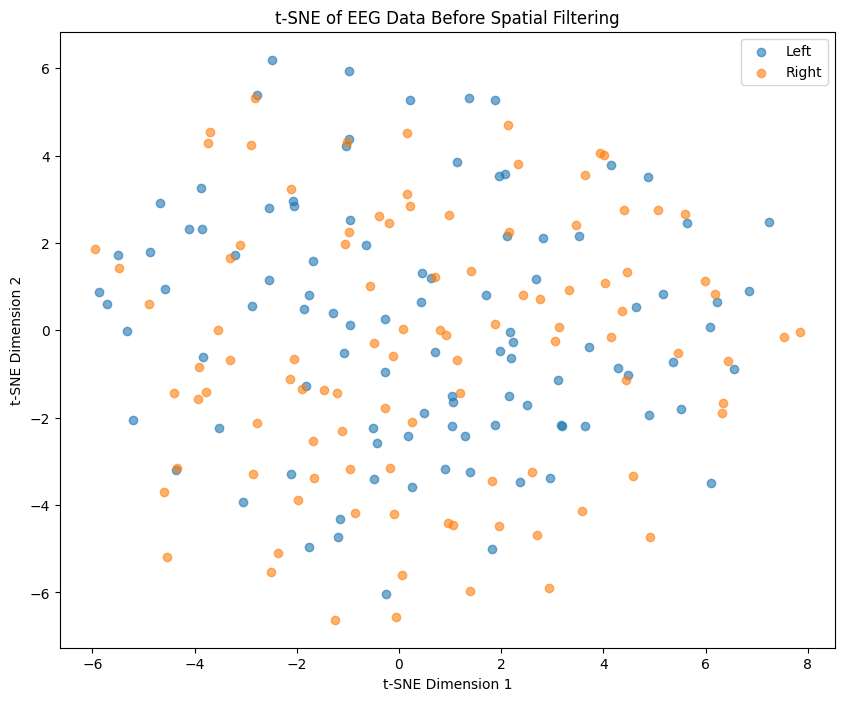

In [23]:
n_samples, n_channels, n_times = dataa.shape
data_2d = dataa.reshape(n_samples, -1)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
data_tsne = tsne.fit_transform(data_2d)

plt.figure(figsize=(10, 8))
plt.scatter(data_tsne[Y == -1, 0], data_tsne[Y == -1, 1], label='Left', alpha=0.6)
plt.scatter(data_tsne[Y == 1, 0], data_tsne[Y == 1, 1], label='Right', alpha=0.6)
plt.legend()
plt.title('t-SNE of EEG Data Before Spatial Filtering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

Bandpass Filter

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 165 samples (1.650 s)



C:\Users\user\AppData\Local\Temp\ipykernel_22736\2868727989.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.compute_psd().plot()
C:\Users\user\AppData\Local\Temp\ipykernel_22736\2868727989.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.compute_psd().plot()
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | e

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\user\AppData\Local\Temp\ipykernel_22736\2868727989.py:10: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.compute_psd().plot() # Power Spectral Density (PSD)
C:\Users\user\AppData\Local\Temp\ipykernel_22736\2868727989.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.compute_psd().plot() # Power Spectral Density (PSD)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\user\AppData\Local\Temp\ipykernel_22736\2868727989.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


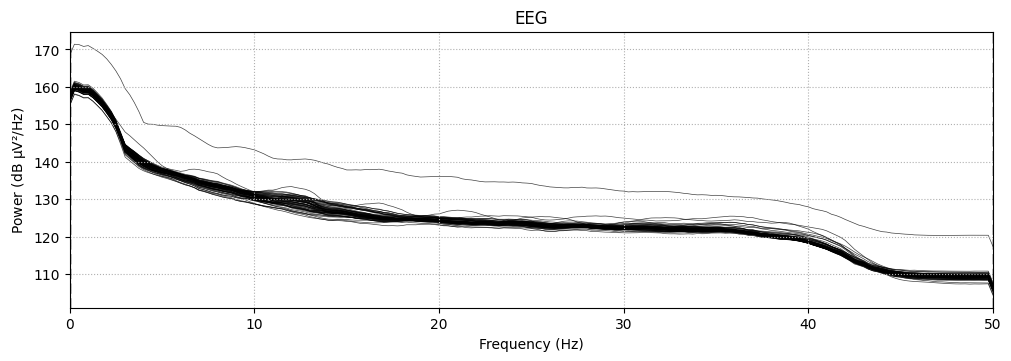

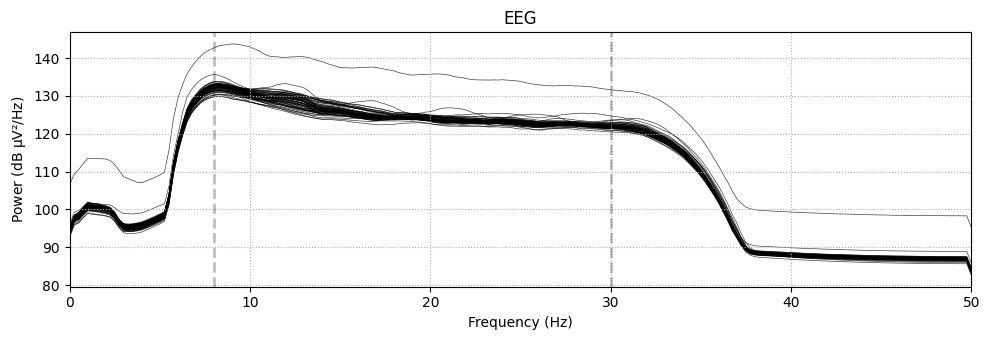

In [24]:
# epochs['left'].average().plot()
# epochs['right'].average().plot()
epochs.compute_psd().plot()

# Bandpass Filter
epochs.filter(l_freq=8, h_freq=30)

# epochs['left'].average().plot()
# epochs['right'].average().plot()
epochs.compute_psd().plot() # Power Spectral Density (PSD)
plt.tight_layout()

Laplacian Filter

{'AF3': array([-0.20109028,  0.68656518,  0.001     ]), 'AF4': array([0.20109028, 0.68656518, 0.001     ]), 'F5': array([-0.48547489,  0.52547424,  0.001     ]), 'F3': array([-0.32894737,  0.46520183,  0.001     ]), 'F1': array([-0.16535231,  0.43208641,  0.001     ]), 'Fz': array([0.      , 0.421549, 0.001   ]), 'F2': array([0.16535231, 0.43208641, 0.001     ]), 'F4': array([0.32894737, 0.46520183, 0.001     ]), 'F6': array([0.48547489, 0.52547424, 0.001     ]), 'FC5': array([-0.60591541,  0.27165704,  0.001     ]), 'FC3': array([-0.39919579,  0.23384348,  0.001     ]), 'FC1': array([-0.19765935,  0.21394494,  0.001     ]), 'FCz': array([0.        , 0.20773757, 0.001     ]), 'FC2': array([0.19765935, 0.21394494, 0.001     ]), 'FC4': array([0.39919579, 0.23384348, 0.001     ]), 'FC6': array([0.60591541, 0.27165704, 0.001     ]), 'CFC7': array([-0.74834683,  0.15177169,  0.001     ]), 'CFC5': array([-0.52472976,  0.12553103,  0.001     ]), 'CFC3': array([-0.30963911,  0.11086096,  0.001

C:\Users\user\AppData\Local\Temp\ipykernel_22736\982091815.py:6: RuntimeWarning: Estimated head radius (170.3 cm) is above the 99th percentile for adult head size.
  laplacian_epochs = mne.preprocessing.compute_current_source_density(epochs, sphere='auto', lambda2=1e-05, stiffness=4, n_legendre_terms=50, copy=True)
C:\Users\user\AppData\Local\Temp\ipykernel_22736\982091815.py:6: RuntimeWarning: (X, Y) fit (-0.4, -46.8) more than 20 mm from head frame origin
  laplacian_epochs = mne.preprocessing.compute_current_source_density(epochs, sphere='auto', lambda2=1e-05, stiffness=4, n_legendre_terms=50, copy=True)


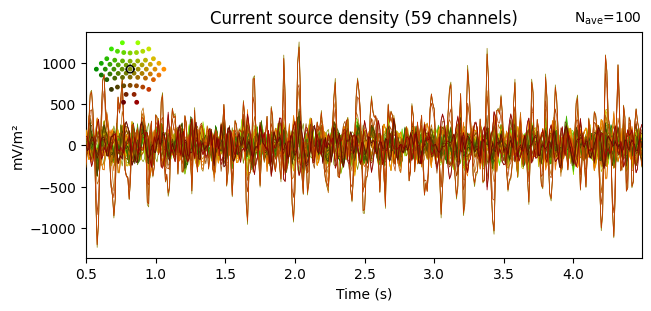

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\user\AppData\Local\Temp\ipykernel_22736\982091815.py:11: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  laplacian_epochs.compute_psd().plot()
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


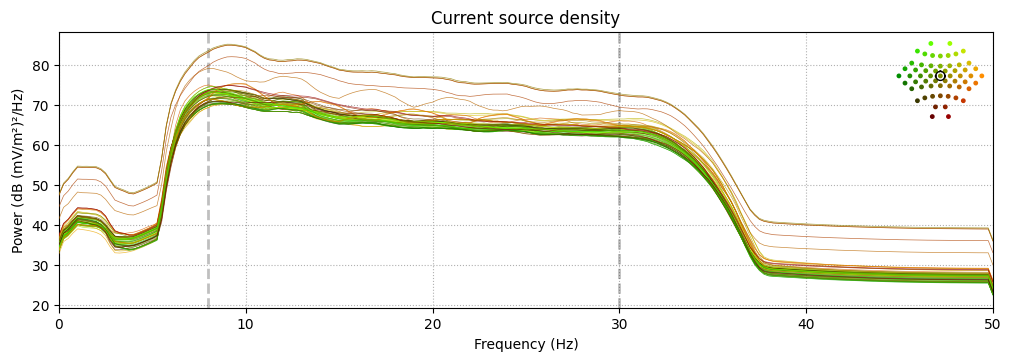

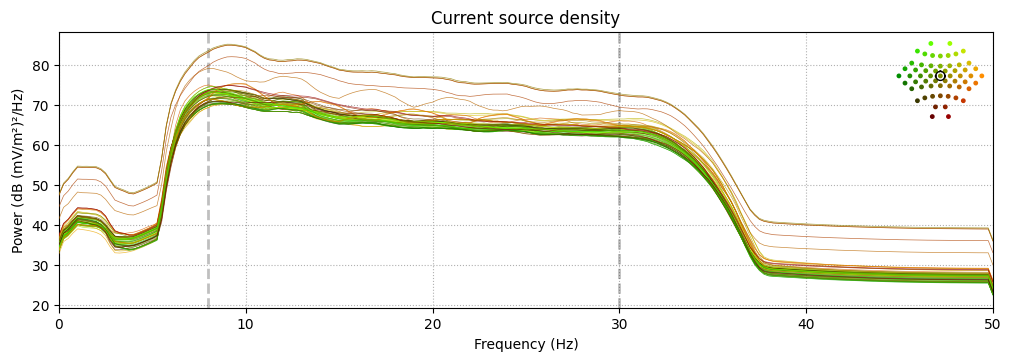

In [25]:
zpos = np.zeros_like(xpos) + 0.001
ch_pos = dict(zip(chan_names, np.column_stack([xpos, ypos, zpos])))
print(ch_pos)
montage = mne.channels.make_dig_montage(ch_pos, coord_frame='head')
epochs.set_montage(montage)
laplacian_epochs = mne.preprocessing.compute_current_source_density(epochs, sphere='auto', lambda2=1e-05, stiffness=4, n_legendre_terms=50, copy=True)

laplacian_epochs['left'].average().plot()
# laplacian_epochs['right'].average().plot()

laplacian_epochs.compute_psd().plot()

ICA Methodology

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\user\AppData\Local\Temp\ipykernel_22736\2316106082.py:9: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs_ica.compute_psd().plot()
C:\Users\user\AppData\Local\Temp\ipykernel_22736\2316106082.py:9: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs_ica.compute_psd().plot()
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


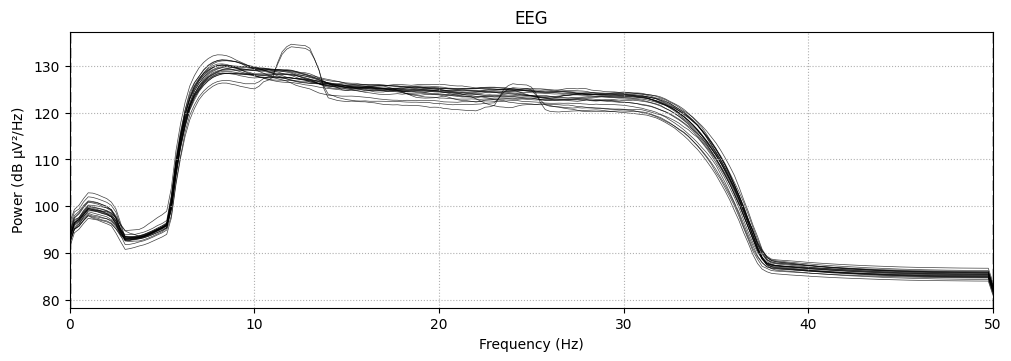

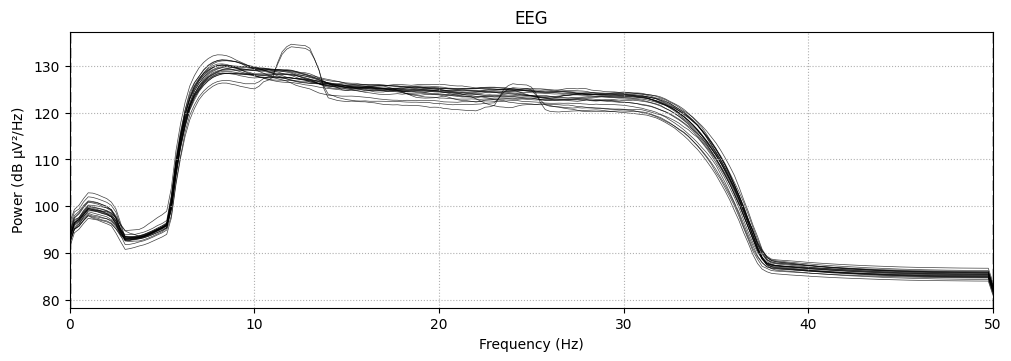

In [26]:
X = epochs.get_data(copy=False)
ICA = mne.decoding.UnsupervisedSpatialFilter(FastICA(21, whiten="unit-variance"), average=False)
ica_data = ICA.fit_transform(X)
epochs_ica = mne.EpochsArray(ica_data, mne.create_info(21, epochs.info["sfreq"], ch_types="eeg"), events, tmin, event_id)

# epochs_ica['left'].average().plot()
# epochs_ica['right'].average().plot()

epochs_ica.compute_psd().plot()

PCA Methodology

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


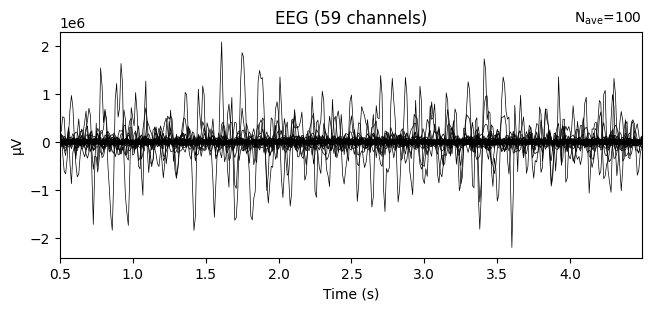

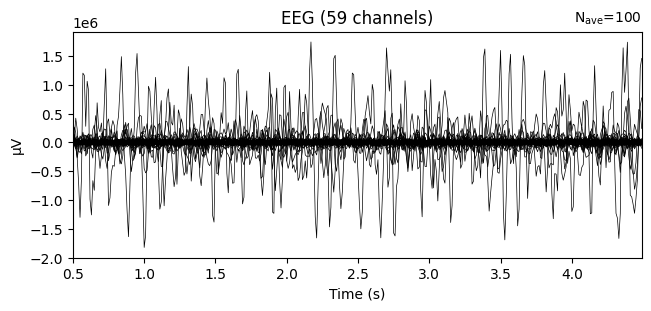

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\user\AppData\Local\Temp\ipykernel_22736\1573665304.py:9: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.compute_psd().plot()
C:\Users\user\AppData\Local\Temp\ipykernel_22736\1573665304.py:9: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.compute_psd().plot()
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


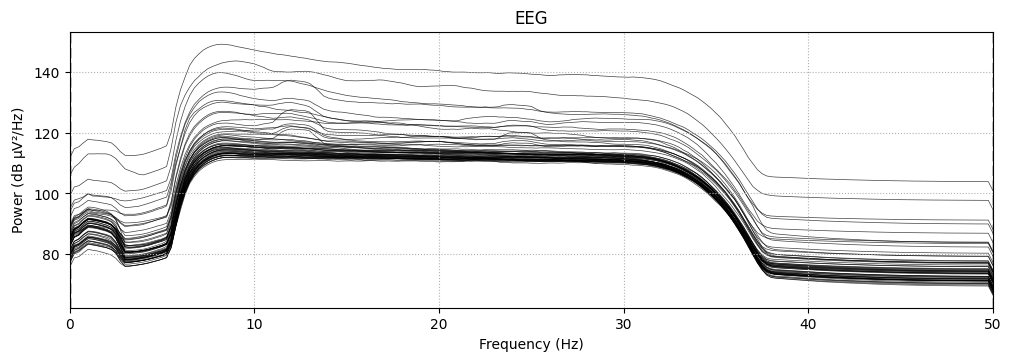

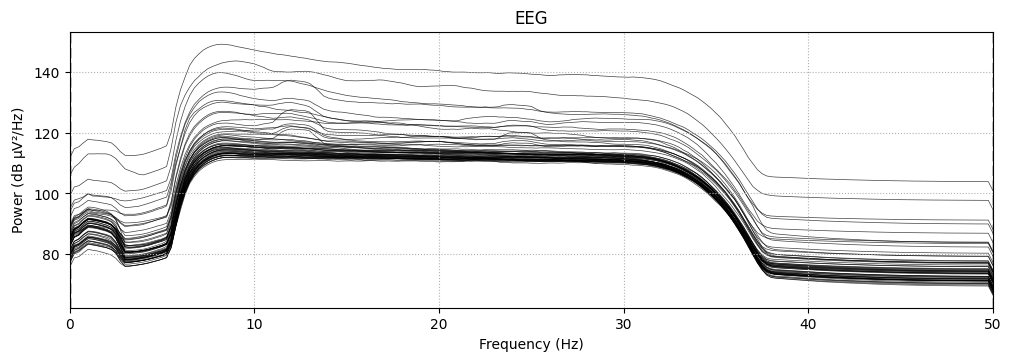

In [27]:
pca = mne.decoding.UnsupervisedSpatialFilter(PCA(59), average=False)
pca_data = pca.fit_transform(X)

epochs = mne.EpochsArray(pca_data, mne.create_info(59, epochs.info["sfreq"], ch_types="eeg"), events, tmin, event_id)

epochs['left'].average().plot()
epochs['right'].average().plot()

epochs.compute_psd().plot()

t-SNE

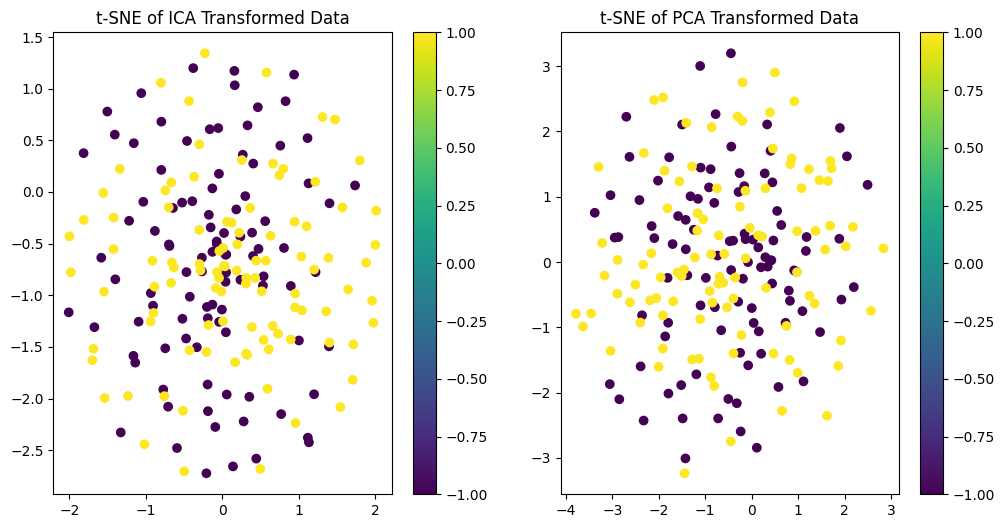

In [28]:
ica_flattened = ica_data.reshape(ica_data.shape[0], -1)
pca_flattened = pca_data.reshape(pca_data.shape[0], -1)

tsne = TSNE(n_components=2, random_state=0)
ica_tsne = tsne.fit_transform(ica_flattened)
pca_tsne = tsne.fit_transform(pca_flattened)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(ica_tsne[:, 0], ica_tsne[:, 1], c=events[:, 2], cmap='viridis')
plt.title('t-SNE of ICA Transformed Data')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(pca_tsne[:, 0], pca_tsne[:, 1], c=events[:, 2], cmap='viridis')
plt.title('t-SNE of PCA Transformed Data')
plt.colorbar()

plt.show()

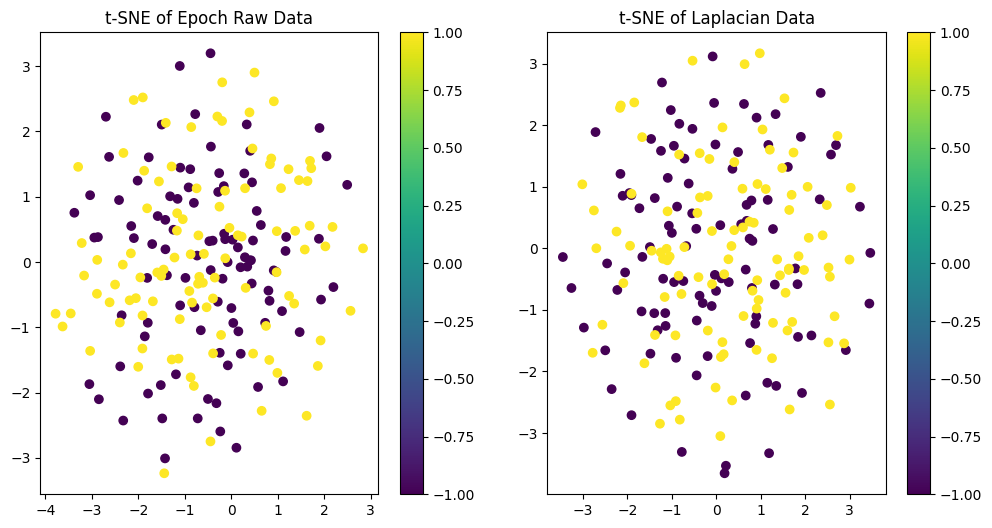

In [29]:
epochs_data = epochs.get_data(copy=False)
epochs_flattened = epochs_data.reshape(epochs_data.shape[0], -1)
laplacian_data = laplacian_epochs.get_data(copy=False)
laplacian_flattened = laplacian_data.reshape(laplacian_data.shape[0], -1)

tsne = TSNE(n_components=2, random_state=0)
epochs_tsne = tsne.fit_transform(epochs_flattened)
laplacian_tsne = tsne.fit_transform(laplacian_flattened)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(epochs_tsne[:, 0], epochs_tsne[:, 1], c=events[:, 2], cmap='viridis')
plt.title('t-SNE of Epoch Raw Data')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(laplacian_tsne[:, 0], laplacian_tsne[:, 1], c=events[:, 2], cmap='viridis')
plt.title('t-SNE of Laplacian Data')
plt.colorbar()

plt.show()

CSP using pca results

Computing rank from data with rank=None


    Using tolerance 12 (2.2e-16 eps * 59 dim * 9.4e+14  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating class=-3 covariance using LEDOIT_WOLF
Done.
Estimating class=-1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 59 dim * 9.8e+14  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating class=-3 covariance using LEDOIT_WOLF
Done.
Estimating class=-1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 59 dim * 9.5e+14  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating class=-3 covariance using LEDOIT_WOLF
Done.
Estimating class=-1 covaria

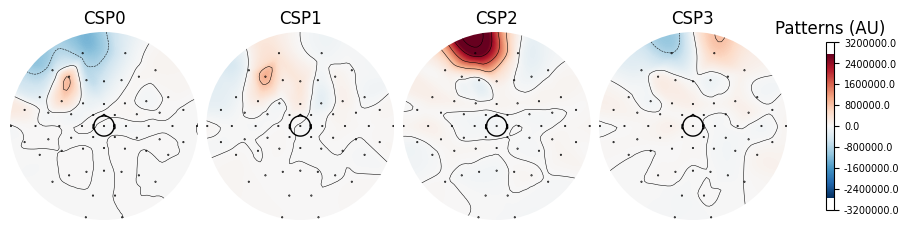

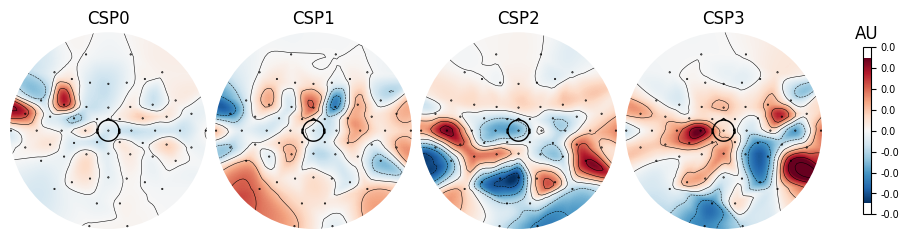

Classification accuracy: 0.945 / Chance level: 0.5


In [30]:
chan_names = epochs.ch_names
xpos = data['nfo']['xpos'][0][0]
ypos = data['nfo']['ypos'][0][0]
zpos = np.zeros_like(xpos) + 0.001

ch_pos = dict(zip(chan_names, np.column_stack([xpos, ypos, zpos])))
custom_montage = mne.channels.make_dig_montage(ch_pos, coord_frame='head')
epochs.set_montage(custom_montage)

epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
epochs_data_train = epochs_train.get_data(copy=False)

epochs_data_train = np.nan_to_num(epochs_data_train)

labels = epochs.events[:, -1] - 2

cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = mne.decoding.CSP(n_components=4, reg='ledoit_wolf', log=True, norm_trace=False)

clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv_split, n_jobs=None)

class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)

csp.fit_transform(epochs_data_train, labels)
csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)
csp.plot_filters(epochs.info, scalings=1e-8, size=1.5)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

Computing rank from data with rank=None
    Using tolerance 24 (2.2e-16 eps * 59 dim * 1.9e+15  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating class=-3 covariance using EMPIRICAL
Done.
Estimating class=-1 covariance using EMPIRICAL
Done.


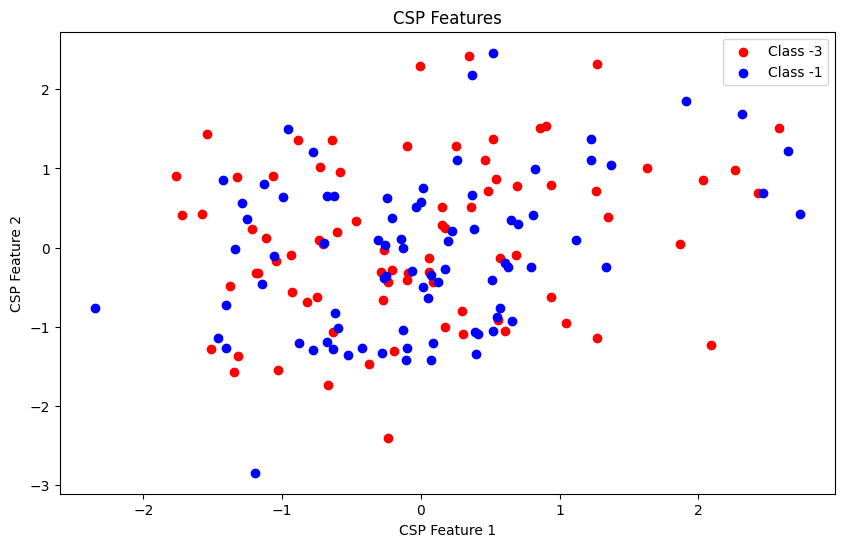

In [31]:
epochs_data = np.array(epochs_data)
labels = np.array(labels)

epochs_data_train, epochs_data_test, labels_train, labels_test = train_test_split(epochs_data, labels, test_size=0.2, random_state=42)

# Initialize and fit CSP
csp = CSP(n_components=2, log=None, transform_into='csp_space')
csp_train_features = csp.fit_transform(epochs_data_train, labels_train)
csp_test_features = csp.transform(epochs_data_test)

# Reshape the CSP features to 2D (samples, features)
n_samples, n_channels, n_times = csp_train_features.shape
csp_train_features_2d = csp_train_features.reshape(n_samples, -1)
csp_test_features_2d = csp_test_features.reshape(epochs_data_test.shape[0], -1)

# Standardize the features for better visualization
scaler = StandardScaler()
csp_train_features_2d = scaler.fit_transform(csp_train_features_2d)
csp_test_features_2d = scaler.transform(csp_test_features_2d)

# Plot CSP features
plt.figure(figsize=(10, 6))
for label, color in zip(np.unique(labels_train), ['r', 'b']):
    plt.scatter(csp_train_features_2d[labels_train == label, 0], csp_train_features_2d[labels_train == label, 1], label=f'Class {label}', c=color)
plt.title('CSP Features')
plt.xlabel('CSP Feature 1')
plt.ylabel('CSP Feature 2')
plt.legend()
plt.show()


Logistic Regression Classifier

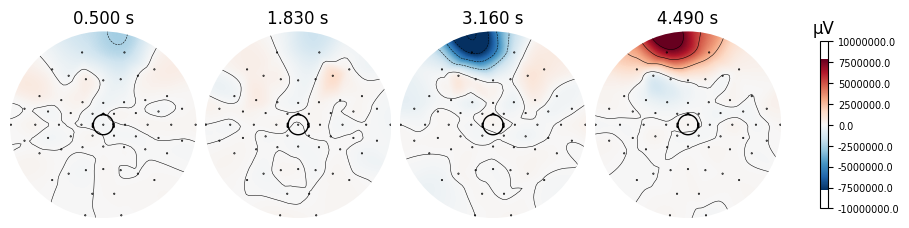

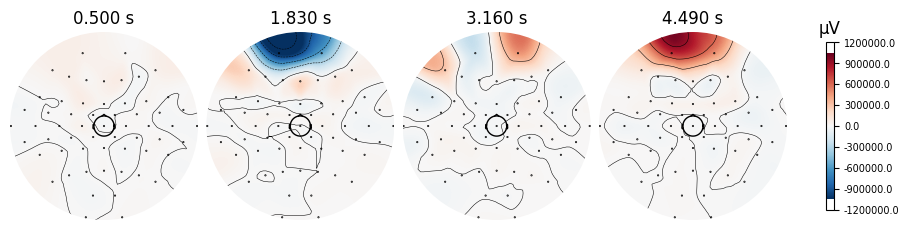

In [32]:
clf = LogisticRegression(solver="liblinear")
scaler = StandardScaler()

eeg_data = epochs.get_data(copy=False).reshape(len(labels), -1)

model = mne.decoding.LinearModel(clf)
X = scaler.fit_transform(eeg_data)
model.fit(X, labels)

for name, coef in (("patterns", model.patterns_), ("filters", model.filters_)):
    coef = scaler.inverse_transform([coef])[0]
    coef = coef.reshape(len(epochs.ch_names), -1)

    evoked = mne.EvokedArray(coef, epochs.info, tmin=epochs.tmin)
    fig = evoked.plot_topomap(size=1.5)
    fig.suptitle(f"EEG {name}")

SVM Classifier

C:\Users\user\AppData\Local\Temp\ipykernel_22736\1400158157.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  clf.fit(epochs.get_data(), labels)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Shape of patterns: (59, 400)


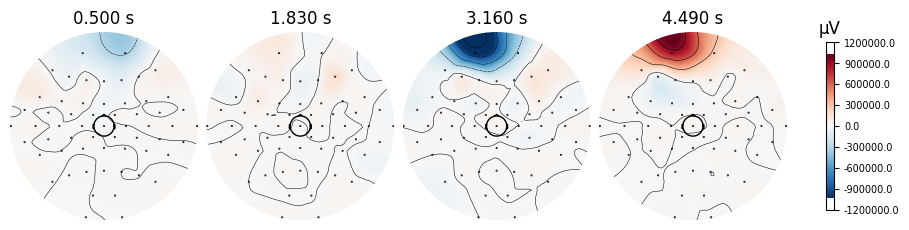

Shape of filters: (59, 400)


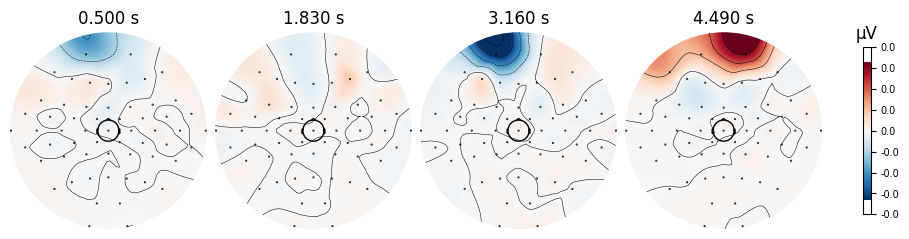

Text(0.5, 0.98, 'EEG Filters')

In [33]:
clf = make_pipeline(mne.decoding.Scaler(epochs.info), mne.decoding.Vectorizer(), mne.decoding.LinearModel(LinearSVC(C=0.1)))
clf.fit(epochs.get_data(), labels)

patterns = mne.decoding.get_coef(clf, 'patterns_', inverse_transform=True)
print("Shape of patterns:", patterns.shape)
evoked_patterns = mne.EvokedArray(patterns, epochs.info, tmin=epochs.tmin)
fig_patterns = evoked_patterns.plot_topomap(size=1.5)
fig_patterns.suptitle("EEG Patterns")

filters = mne.decoding.get_coef(clf, 'filters_', inverse_transform=True)
print("Shape of filters:", filters.shape)
evoked_filters = mne.EvokedArray(filters, epochs.info, tmin=epochs.tmin)
fig_filters = evoked_filters.plot_topomap(size=1.5)
fig_filters.suptitle("EEG Filters")

KNN Classifier

C:\Users\user\AppData\Local\Temp\ipykernel_22736\2635857216.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  clf.fit(epochs.get_data(), labels)
C:\Users\user\AppData\Local\Temp\ipykernel_22736\2635857216.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  predictions = clf.predict(epochs.get_data())
C:\Users\user\AppData\Local\Temp\ipykernel_22736\2635857216.py:10: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  plt.plot(epochs.get_data()[i].T)


Predictions: [-1 -1 -1 -1 -3 -3 -1 -3 -3 -3]


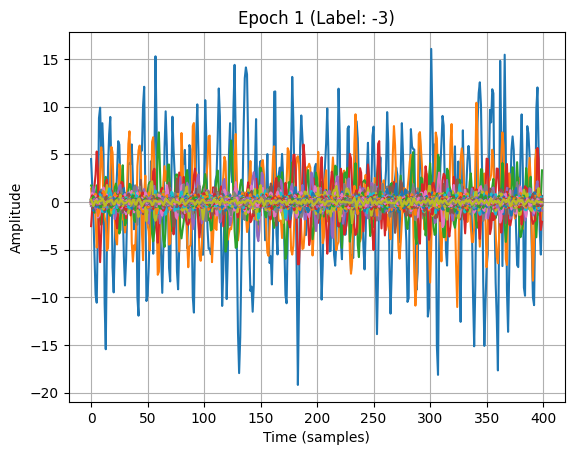

C:\Users\user\AppData\Local\Temp\ipykernel_22736\2635857216.py:10: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  plt.plot(epochs.get_data()[i].T)


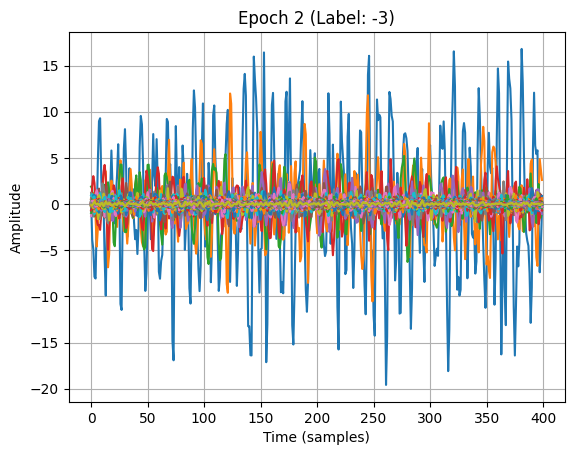

C:\Users\user\AppData\Local\Temp\ipykernel_22736\2635857216.py:10: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  plt.plot(epochs.get_data()[i].T)


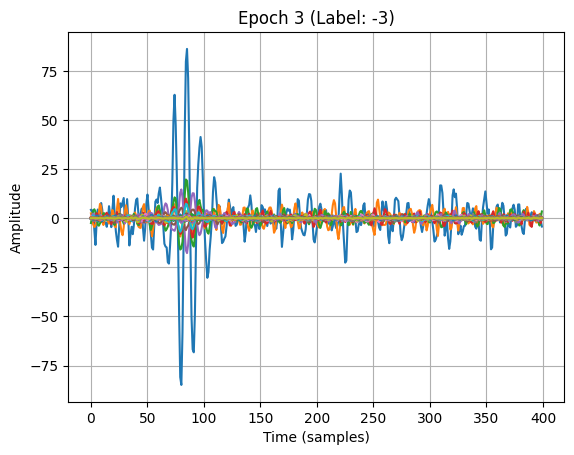

C:\Users\user\AppData\Local\Temp\ipykernel_22736\2635857216.py:10: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  plt.plot(epochs.get_data()[i].T)


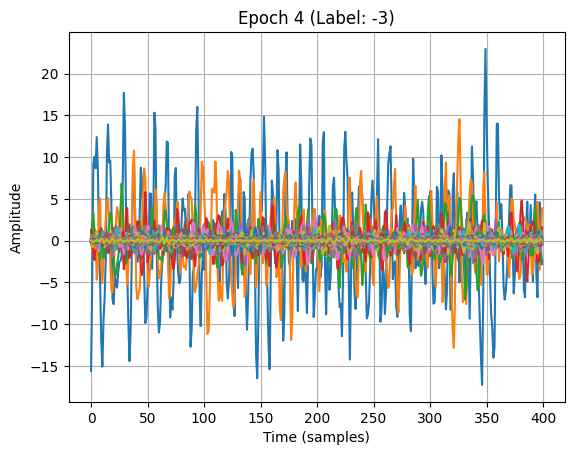

C:\Users\user\AppData\Local\Temp\ipykernel_22736\2635857216.py:10: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  plt.plot(epochs.get_data()[i].T)


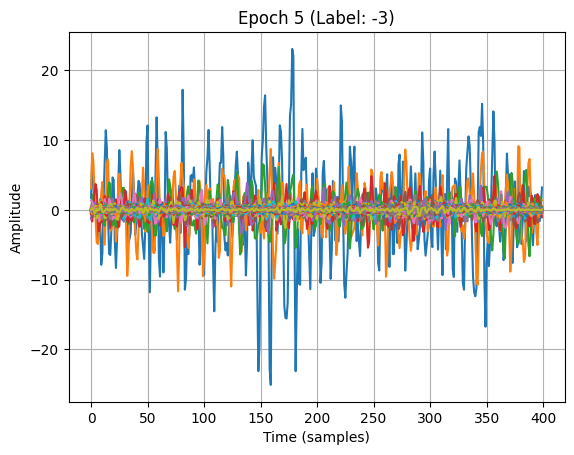

In [34]:
clf = make_pipeline(mne.decoding.Scaler(epochs.info), mne.decoding.Vectorizer(), KNeighborsClassifier(n_neighbors=5))
clf.fit(epochs.get_data(), labels)

predictions = clf.predict(epochs.get_data())

print("Predictions:", predictions[:10])

for i in range(5):
    plt.figure()
    plt.plot(epochs.get_data()[i].T)
    plt.title(f'Epoch {i+1} (Label: {labels[i]})')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

ROC and Confusion Matrix of Classifiers

Computing rank from data with rank=None


    Using tolerance 14 (2.2e-16 eps * 59 dim * 1.1e+15  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


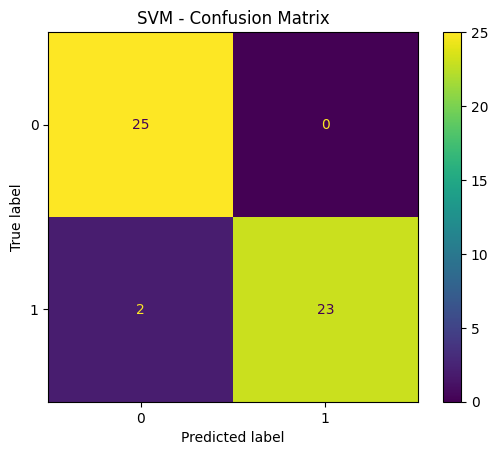

SVM Classification accuracy: 0.96
SVM ROC AUC: 1.0


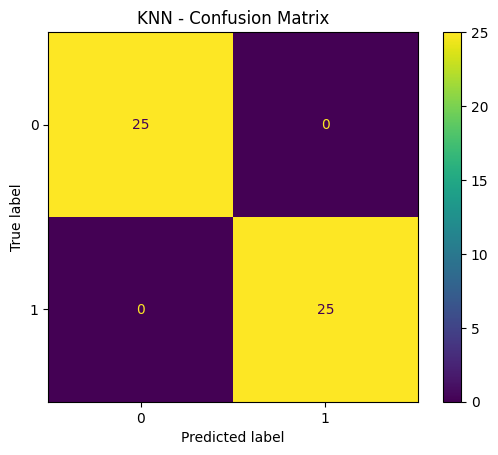

KNN Classification accuracy: 1.0
KNN ROC AUC: 1.0


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


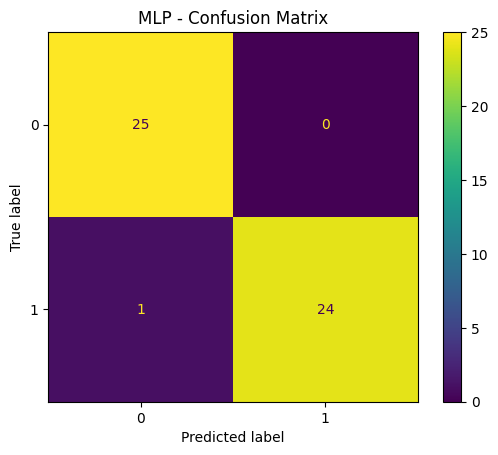

MLP Classification accuracy: 0.98
MLP ROC AUC: 1.0


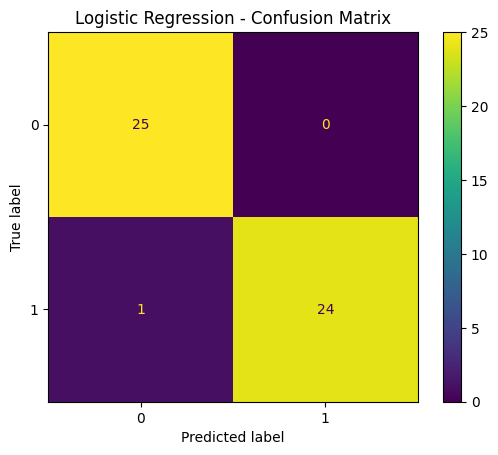

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:24:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Logistic Regression Classification accuracy: 0.98
Logistic Regression ROC AUC: 1.0


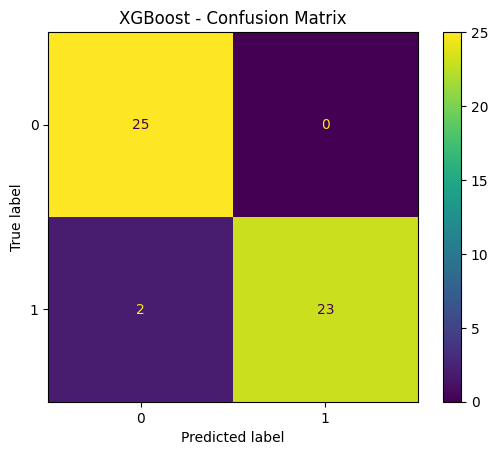

XGBoost Classification accuracy: 0.96
XGBoost ROC AUC: 1.0


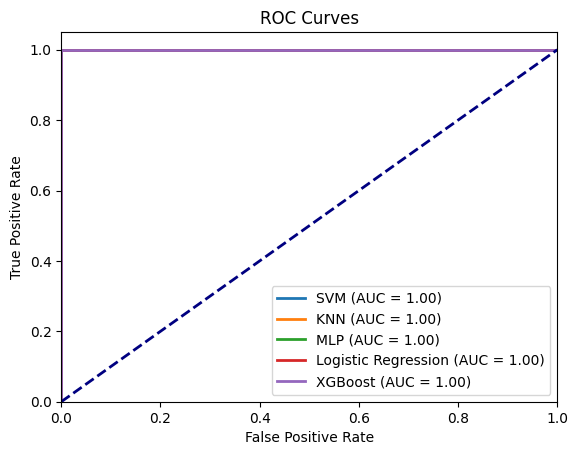

In [35]:
def evaluate_model(model, model_name, roc_curves):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, roc_auc, model_name))

    accuracy = np.mean(y_pred == y_test)
    print(f"{model_name} Classification accuracy: {accuracy}")
    print(f"{model_name} ROC AUC: {roc_auc}")
    #print(f"{model_name} Confusion Matrix:\n{cm}")

montage = mne.channels.make_dig_montage(ch_pos, coord_frame='head')
epochs.set_montage(montage)

epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
epochs_data_train = epochs_train.get_data(copy=False)

labels = epochs.events[:, -1]

cv = ShuffleSplit(10, test_size=0.25, random_state=42)

csp = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)
X_csp = csp.fit_transform(epochs_data_train, labels)

labels_binary = (labels > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_csp, labels_binary, test_size=0.25, random_state=2, stratify=labels_binary)

models = [
    (SVC(kernel='linear', probability=True), "SVM"),
    (KNeighborsClassifier(n_neighbors=5), "KNN"),
    (MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=1), "MLP"),
    (LogisticRegression(solver='lbfgs', max_iter=1000), "Logistic Regression"),
    (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), "XGBoost")
]

roc_curves = []

for model, model_name in models:
    evaluate_model(model, model_name, roc_curves)

plt.figure()
for fpr, tpr, roc_auc, model_name in roc_curves:
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()


Clustering

Silhouette scores for K-means

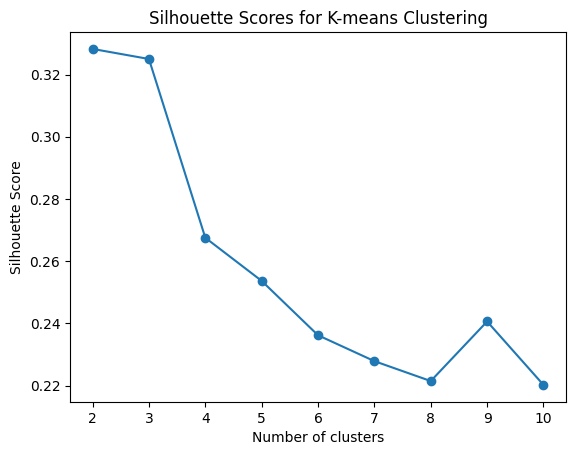

In [39]:
scaler = StandardScaler()
X_csp_scaled = scaler.fit_transform(X_csp)

def optimal_clusters_Kmeans(data, max_k=10):
    scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        scores.append(score)
    return scores

# Calculate silhouette scores for K-means
kmeans_scores = optimal_clusters_Kmeans(X_csp_scaled)
optimal_k_kmeans = np.argmax(kmeans_scores) + 2  # +2 because we start from k=2

# Plot silhouette scores
plt.figure()
plt.plot(range(2, len(kmeans_scores) + 2), kmeans_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for K-means Clustering')
plt.show()

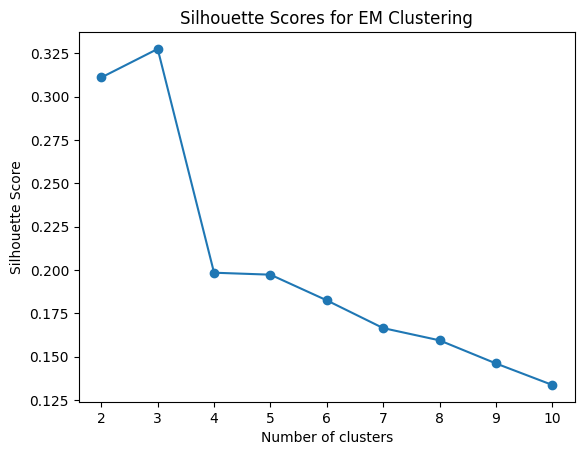

In [40]:
def optimal_clusters_EM(data, max_k=10):
    scores = []
    for k in range(2, max_k + 1):
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(data)
        labels = gmm.predict(data)
        score = silhouette_score(data, labels)
        scores.append(score)
    return scores

# Calculate silhouette scores for K-means
gmm_scores = optimal_clusters_EM(X_csp_scaled)
optimal_k_EM = np.argmax(gmm_scores) + 2  # +2 because we start from k=2

# Plot silhouette scores
plt.figure()
plt.plot(range(2, len(gmm_scores) + 2), gmm_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for EM Clustering')
plt.show()

K-means - Silhouette Score: 0.3282431810858516
K-means - Davies-Bouldin Index: 1.2288775871874669
GMM - Silhouette Score: 0.3275788189983024
GMM - Davies-Bouldin Index: 1.236658770751862


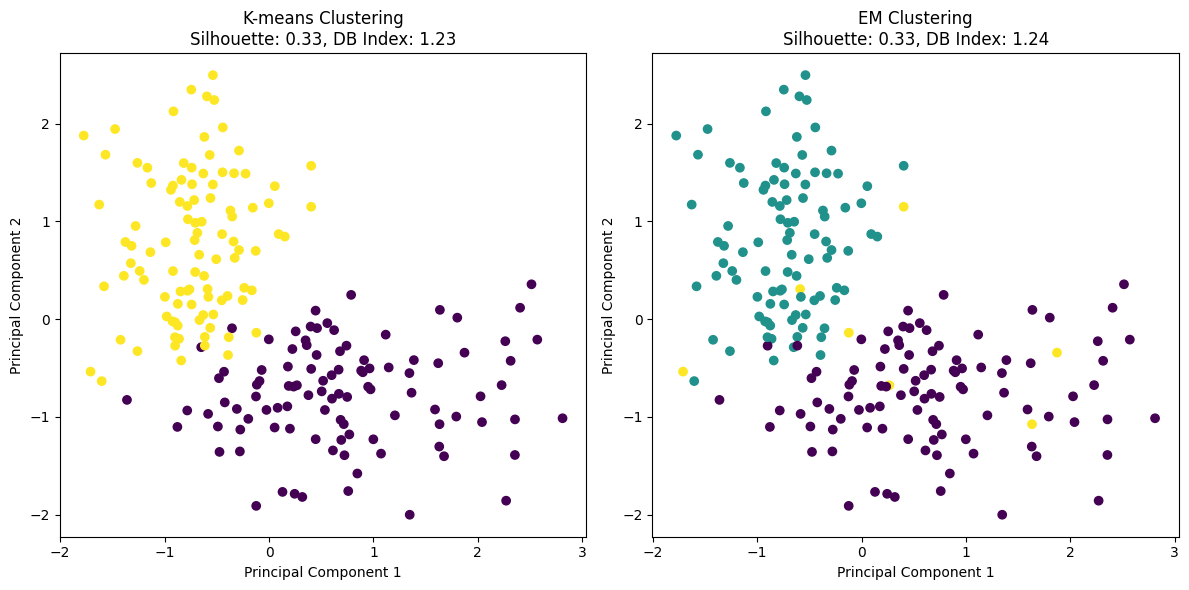

In [43]:
def calculate_cluster_metrics(data, labels, method_name):
    silhouette_avg = silhouette_score(data, labels)
    db_index = davies_bouldin_score(data, labels)
    print(f"{method_name} - Silhouette Score: {silhouette_avg}")
    print(f"{method_name} - Davies-Bouldin Index: {db_index}")
    return silhouette_avg, db_index

kmeans = KMeans(n_clusters=optimal_k_kmeans, random_state=42, n_init = 10)
kmeans_labels = kmeans.fit_predict(X_csp_scaled)

gmm = GaussianMixture(n_components=optimal_k_EM, random_state=42)
gmm_labels = gmm.fit_predict(X_csp_scaled)


kmeans_silhouette, kmeans_db = calculate_cluster_metrics(X_csp_scaled, kmeans_labels, "K-means")
gmm_silhouette, gmm_db = calculate_cluster_metrics(X_csp_scaled, gmm_labels, "GMM")

plt.figure(figsize=(12, 6))
#K-means clustering
plt.subplot(1, 2, 1)
plt.scatter(X_csp_scaled[:, 0], X_csp_scaled[:, 1], c=kmeans_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'K-means Clustering\nSilhouette: {kmeans_silhouette:.2f}, DB Index: {kmeans_db:.2f}')

#EM clustering
plt.subplot(1, 2, 2)
plt.scatter(X_csp_scaled[:, 0], X_csp_scaled[:, 1], c=gmm_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'EM Clustering\nSilhouette: {gmm_silhouette:.2f}, DB Index: {gmm_db:.2f}')

plt.tight_layout()
plt.show()